In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import date, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Base.metadata.tables

immutabledict({'measurement': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), 'station': Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)})

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station  = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# engine.execute('SELECT * FROM Measurement Where date>= ''2016-08-24'' ').fetchall()

# mammals = session.query(Measurement).filter(Measurement.date <= 'Antilocapra').all()
# for mammal in mammals:
#     print(f"Family: {mammal.family}, Genus: {mammal.genus}")

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(func.max(Measurement.date)).scalar()
max_date

'2017-08-23'

In [12]:
# Calculate the date 1 year ago from the last data point in the database
min_date = date(2017, 8, 23) - timedelta(365)
query_date = min_date.isoformat()
query_date

'2016-08-23'

In [13]:
# # Perform a query to retrieve the data and precipitation scores
# query = f'SELECT date, prcp FROM Measurement WHERE date >= {query_date};'

# queryB =  "SELECT date, prcp FROM Measurement WHERE date >=" + query_date + ";"

# # Save the query results as a Pandas DataFrame and set the index to the date column
# measurement_df = pd.read_sql_query(query, con=engine, index_col= 'date', parse_dates = 'date')
# measurement_df

# # Sort the dataframe by date
# plot_df = measurement_df.sort_values(by='date', ascending=False)
# plot_df

In [14]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
query = session.query(*sel).\
    filter(Measurement.date >= query_date).\
    order_by(Measurement.date).all()

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp = pd.DataFrame(query, columns =['Date','Precipitation']) 
plot_df = prcp.set_index('Date')

In [17]:
# Sort the dataframe by date
plot_df = plot_df.sort_values(by='Date', ascending=True)

# plot_df['Date'] = pd.to_datetime(prcp['Date'])

# droping null values
plot_df.dropna()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


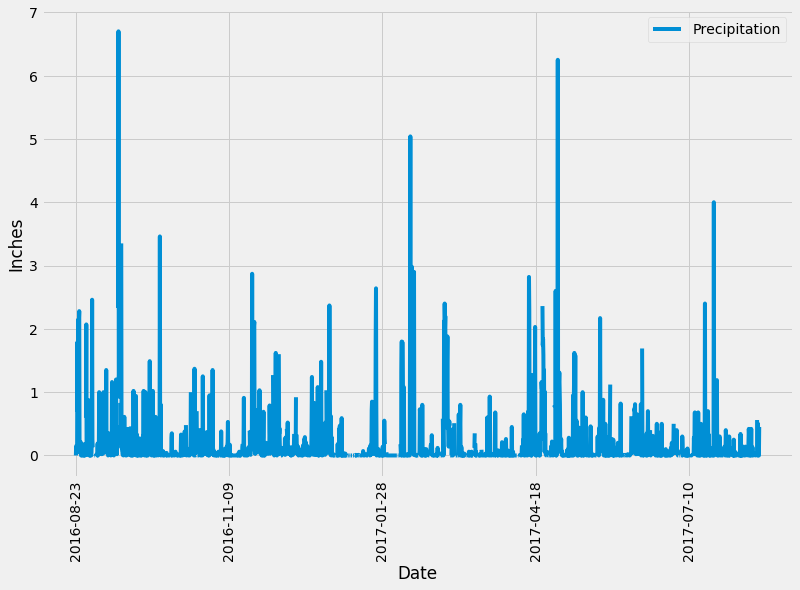

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
plot_df.plot(label="Label", rot=90, figsize=(12,8))
plt.ylabel("Inches")
plt.legend()
plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
plot_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
# Design a query to show how many stations are available in this dataset?
query_stations = 'SELECT * FROM Station'

df = pd.read_sql_query(query_stations, con=engine)
df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [23]:
# Using ORM
results = session.query(Station.station).all()
results

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [24]:
# Save the query results as a Pandas DataFrame
sel = [Station.id,
       Station.station, 
       func.round(func.min(Measurement.tobs)), 
       func.round(func.max(Measurement.tobs)), 
       func.round(func.avg(Measurement.tobs)), 
       func.round(func.count(Measurement.tobs))]

query2 =  session.query(*sel).group_by(Station.station).filter(Station.station == Measurement.station).all()

station_df = pd.DataFrame(query2, columns =['Id','Station', 'Lowest', 'Highest','Avg','Cnt']) 

In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_df.sort_values(by='Cnt', ascending=False)

,Id,Station,Lowest,Highest,Avg,Cnt
6,7,USC00519281,54.0,85.0,72.0,2772.0
7,1,USC00519397,56.0,87.0,75.0,2724.0
1,2,USC00513117,59.0,85.0,73.0,2709.0
8,6,USC00519523,56.0,85.0,75.0,2669.0
3,9,USC00516128,58.0,84.0,71.0,2612.0
2,3,USC00514830,58.0,85.0,75.0,2202.0
0,8,USC00511918,53.0,87.0,72.0,1979.0
4,4,USC00517948,58.0,87.0,75.0,1372.0
5,5,USC00518838,58.0,83.0,73.0,511.0


In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

highest_station = station_df.loc[station_df['Id'] == 7]
highest_station

,Id,Station,Lowest,Highest,Avg,Cnt
6,7,USC00519281,54.0,85.0,72.0,2772.0


In [101]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 

# top_query = session.query(Measurement.tobs, func.round(func.count(Measurement.date))).\
#     filter(Measurement.date >= query_date).\
#     filter(Measurement.station == "USC00519281").\
#     group_by(Measurement.tobs).all()

top_query = session.query(Measurement.tobs).\
    filter(Measurement.date >= query_date).\
    filter(Measurement.station == "USC00519281").all()

In [103]:
hist_plot = pd.DataFrame(top_query, columns =['Temperature']) 
# hist_plot = station_df.set_index('Temperature')
hist_plot

,Temperature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


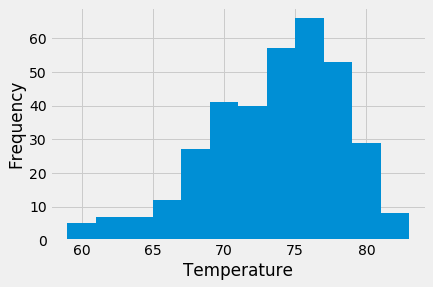

In [107]:
# and plot the results as a histogram
plt.hist(hist_plot['Temperature'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
